In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import joblib as jl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

root = 'dl'

Using TensorFlow backend.


# Load raw data

In [2]:
labels = pd.read_csv('../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
labels.head()

,CLASS
PIN,
568483,1
923748,0
2035328,0
2239386,1
2244533,1


In [3]:
data = jl.load(open('../../tmp/item_days_raw_data_.pkl', 'rb')).loc[labels.index, 'seq']
df = pd.DataFrame(columns=['Seq', 'Class'], index=data.index)
df.loc[:, 'Seq'] = data
df.loc[:, 'Class'] = labels['CLASS']
df.head()

,Seq,Class
PIN,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1


# Separate MBS items and timepoints

In [4]:
for idx in df.index:
    _tmp = df.loc[idx, 'Seq'].split(' ')
    df.loc[idx, 'mbs_seq'] = ' '.join(_tmp[::2])
    df.loc[idx, 'times_seq'] = ' '.join(_tmp[1::2])

In [5]:
df.head()

,Seq,Class,mbs_seq,times_seq
PIN,,,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1,10990 23 725 10990 10990 10990 10993 23 85311 ...,0 16 0 0 0 0 0 15 0 0 13 0 0 0 22 0 0 0 0 0 0 ...
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0,66653 65070 66515 10962 105 56807 10990 23 109...,0 0 5 1 1 42 0 26 35 0 0 0 9 0 0 0 5 0 0 0 21 ...
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0,66536 74995 66512 66551 66608 66716 66560 7392...,0 0 0 0 0 0 0 9 1 10 9 138 1 3 31 24 63 0 0 0 ...
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1,10991 23 73928 66560 66515 66551 66536 2517 10...,0 105 0 0 0 0 4 2 27 1 1 7 0 18 132 0 0 0 1 0 ...
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1,10990 23 23 10990 73928 66500 66560 66551 23 1...,0 74 0 1 0 0 0 2 0 87 0 1 0 0 0 0 0 2 0 6 0 8 ...


# Seq2Tokens

In [6]:
# Define tokenizer object
tokenizer = Tokenizer(char_level=False, lower=False, split=' ')

# Fit on corpus and extract tokenized sequences
tokenizer.fit_on_texts(df['mbs_seq'])
n_feat = len(tokenizer.word_index.keys())
print(n_feat)
seq = tokenizer.texts_to_sequences(df['mbs_seq'])

# Pad tokenized sequences
lengths = [len(x) for x in seq]
maxlen = int(np.percentile(lengths, 95))
p_seq = pad_sequences(seq, maxlen=maxlen)
print(p_seq.shape)

# Pad timestamps
t_seq = [map(int, df.loc[idx, 'times_seq'].split(' ')) for idx in df.index]
p_t_seq = pad_sequences(t_seq, maxlen=maxlen)
print(p_t_seq.shape)

2773
(11744, 445)
(11744, 445)


# Training - Validation - Test split

In [7]:
# Full dataset
y = df['Class'].ravel()
X = p_seq
X_t = p_t_seq

# Learn / Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)
learn_idx, test_idx = next(sss.split(X, y))

X_learn, y_learn = X[learn_idx, :], y[learn_idx]
X_test, y_test = X[test_idx, :], y[test_idx]

X_learn_t = X_t[learn_idx, :]
X_test_t = X_t[test_idx, :]

print('{} learn / {} test'.format(len(y_learn), len(y_test)))

# Training / Validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
train_idx, valid_idx = next(sss.split(X_learn, y_learn))

X_train, y_train = X_learn[train_idx, :], y_learn[train_idx]
X_valid, y_valid = X_learn[valid_idx, :], y_learn[valid_idx]

X_train_t = X_learn_t[train_idx, :]
X_valid_t = X_learn_t[valid_idx, :]

print('{} training / {} validation'.format(len(y_train), len(y_valid)))

7046 learn / 4698 test
6341 training / 705 validation


# Init embedding matrix

In [18]:
D = 300
embedding = pd.read_csv('../../tmp/embedding.{}d.csv'.format(D), header=0, index_col=0)
embedding_matrix = embedding.values

# Model

In [20]:
import mbspbs10pc.model as mbs_model
reload(mbs_model);
from keras.layers import CuDNNLSTM
from keras import optimizers as opt

model = mbs_model.build_model(mbs_input_shape=(maxlen,),
                              timestamp_input_shape=(maxlen, 1),
                              vocabulary_size=n_feat,
                              embedding_size=D,
                              recurrent_units=64,
                              dense_units=128,
                              LSTMLayer=CuDNNLSTM,
                              bidirectional=True,
                              single_attention=False)

model.compile(optimizer=opt.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['acc'])


In [21]:
model.get_layer('mbs_embedding').set_weights([embedding_matrix])
model.get_layer('mbs_embedding').trainable = True

In [22]:
# model.summary()

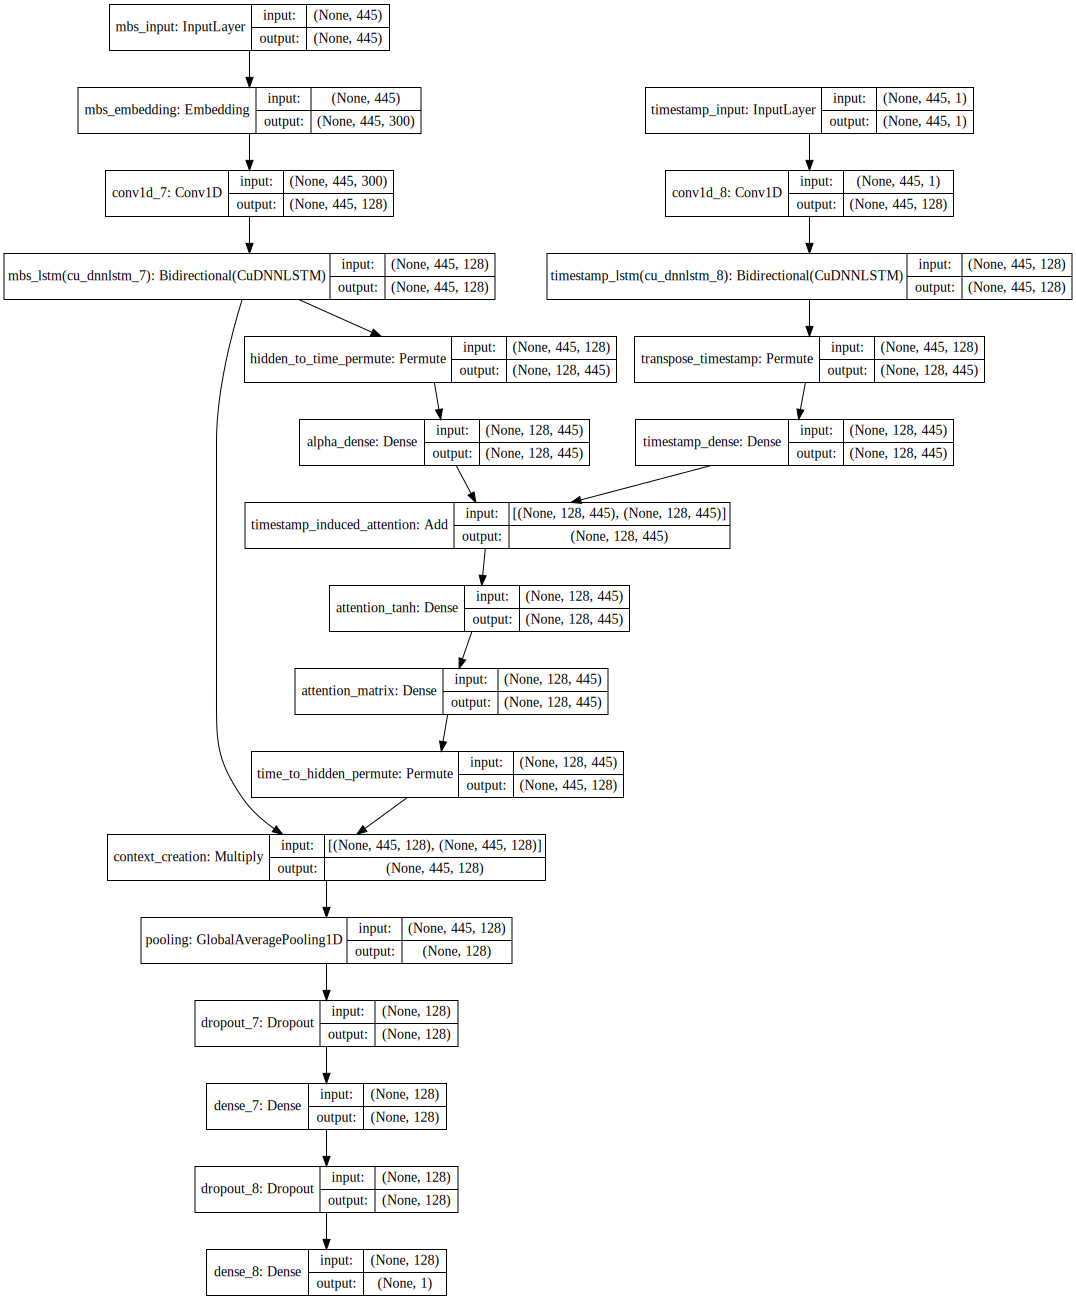

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1),
             EarlyStopping(monitor='val_loss', patience=15)] 

history = model.fit([X_train, X_train_t.reshape(len(y_train), maxlen, 1)], y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=([X_valid, X_valid_t.reshape(len(y_valid), maxlen, 1)], y_valid))

Train on 6341 samples, validate on 705 samples
Epoch 1/100
6341/6341 [==============================] - 24s 4ms/step - loss: 0.7489 - acc: 0.4990 - val_loss: 0.7340 - val_acc: 0.4993
Epoch 2/100
6341/6341 [==============================] - 22s 3ms/step - loss: 0.7198 - acc: 0.5701 - val_loss: 0.7004 - val_acc: 0.6723
Epoch 3/100
6341/6341 [==============================] - 22s 3ms/step - loss: 0.7002 - acc: 0.6431 - val_loss: 0.7015 - val_acc: 0.6723
Epoch 4/100
6341/6341 [==============================] - 22s 3ms/step - loss: 0.6915 - acc: 0.6572 - val_loss: 0.7012 - val_acc: 0.6695
Epoch 5/100
6341/6341 [==============================] - 22s 3ms/step - loss: 0.6810 - acc: 0.6778 - val_loss: 0.7106 - val_acc: 0.5872
Epoch 6/100
6341/6341 [==============================] - 22s 3ms/step - loss: 0.6730 - acc: 0.6819 - val_loss: 0.6773 - val_acc: 0.6667
Epoch 7/100
6341/6341 [==============================] - 22s 3ms/step - loss: 0.6704 - acc: 0.6811 - val_loss: 0.6806 - val_acc: 0.6908
E

KeyboardInterrupt: 

In [ ]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()

In [ ]:
y_pred = model.predict([X_test, X_test_t.reshape(len(y_test), maxlen, 1)]).ravel()

In [ ]:
loss = metrics.log_loss(y_test, y_pred)
acc = metrics.accuracy_score(y_test, y_pred > 0.5)
prec = metrics.precision_score(y_test, y_pred > 0.5)
rcll = metrics.recall_score(y_test, y_pred > 0.5)
auc = metrics.roc_auc_score(y_test, y_pred)
print('Test scores:\n * Log-Loss\t{}\n * Accuracy:\t{}\n '
      '* Precision:\t{}\n * Recall:\t{}\n * AUC: \t{}'.format(loss, acc, prec, rcll, auc))

In [ ]:
from mbspbs10pc.plotting import *

# Plot non-normalized confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred > 0.5)
plt.figure(dpi=100)
plot_confusion_matrix(cnf_matrix, classes=['METONLY', 'METX'],
                      title='Confusion matrix', cmap=plt.cm.Blues);

**TOP results so far [6341 training / 705 validation / 4698 test]**

Test scores:
 * Log-Loss	0.425300993082
 * Accuracy:	0.810131971052
 * Precision:	0.817983413357
 * Recall:	0.797786292039
 * AUC: 	0.894714579232

In [155]:
# model.save_weights('model.h5')

In [ ]:
model.load_weights('model.h5')

# Attention viz

In [27]:
from mbspbs10pc import read_activations
reload(read_activations);

_x_test = [X_test, X_test_t.reshape(len(y_test), maxlen, 1)]
a = read_activations.get_activations(model, _x_test, print_shape_only=True, layer_name='attention_matrix')

----- activations -----
(4698, 128, 445)


In [32]:
true_pos_idx = np.where(np.logical_and(y_test == 1, y_pred >= 0.5))[0]
true_neg_idx = np.where(np.logical_and(y_test == 0, y_pred < 0.5))[0]
false_pos_idx = np.where(np.logical_and(y_test == 1, y_pred < 0.5))[0]
false_neg_idx = np.where(np.logical_and(y_test == 0, y_pred >= 0.5))[0]

In [64]:
def get_att(att, idx):
    return np.mean(np.mean(att[0][idx, :, :], axis=0), axis=0)

true_pos_att = get_att(a, true_pos_idx)
true_neg_att = get_att(a, true_neg_idx)
false_pos_att = get_att(a, false_pos_idx)
false_neg_att = get_att(a, false_neg_idx)

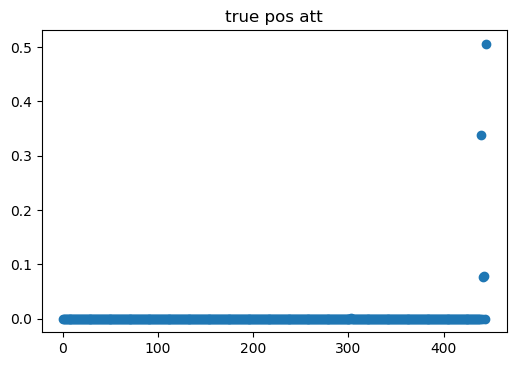

In [71]:
plt.figure(dpi=100)
plt.title('true pos att')
plt.plot(np.arange(445), true_pos_att, 'o');

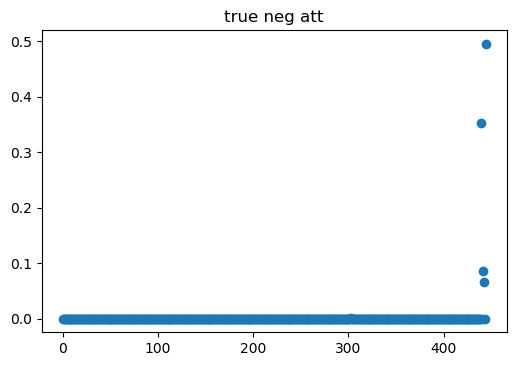

In [72]:
plt.figure(dpi=100)
plt.title('true neg att')
plt.plot(np.arange(445), true_neg_att, 'o');

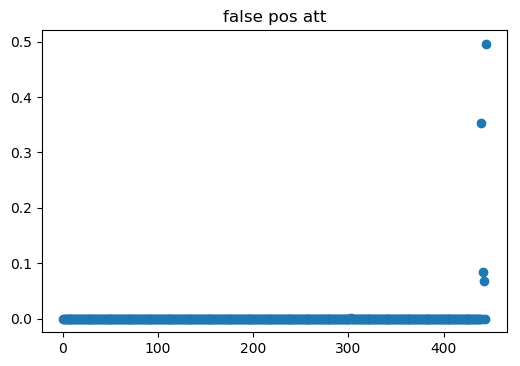

In [73]:
plt.figure(dpi=100)
plt.title('false pos att')
plt.plot(np.arange(445), false_pos_att, 'o');

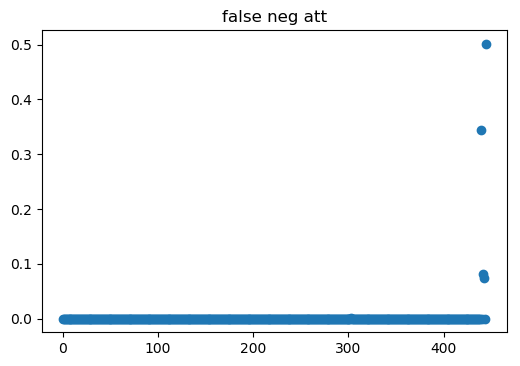

In [74]:
plt.figure(dpi=100)
plt.title('false neg att')
plt.plot(np.arange(445), false_neg_att, 'o');